In [1]:
from simulating_traces.Simulate_measurement import *
import matplotlib.pyplot as plt

## Import data

In [2]:
import json
id_1=2
with open('JPA_off_vs_power_'+str(id_1)+'.json', 'r') as file:
    signal_parameters_fit_read=json.load(file)

## Generate new traces

In [3]:
# Generates distance

# SIMULATION- CREATE DATA

A=signal_parameters_fit_read["A"]
t_in=signal_parameters_fit_read["t_in"]
t_out=signal_parameters_fit_read["t_out"]


E_low=signal_parameters_fit_read["mean_bg"]
E_high=signal_parameters_fit_read["mean_up"]
sigma_low=signal_parameters_fit_read["std_bg"]
sigma_high=signal_parameters_fit_read["std_up"]

E_low=0
E_high=1
sigma_low=0.3
sigma_high=0.3



n_traces=10000
t_max=2000
acq_rate=2

time,spin_traces,spin_number=simulate_measurement(A, t_out, t_in, E_low, sigma_low , E_high, sigma_high, n_traces, t_max, acq_rate)

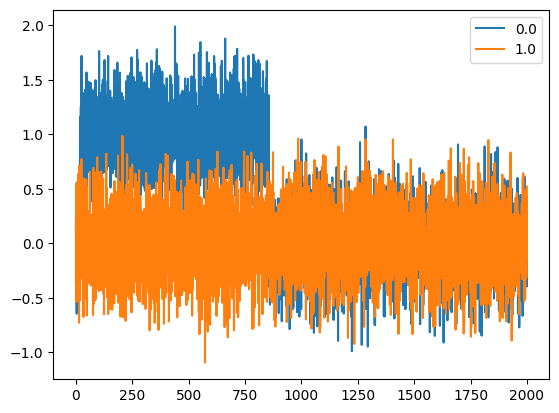

In [4]:

plt.plot(time, spin_traces[0], label=spin_number[0])
plt.plot(time, spin_traces[1], label=spin_number[1])
plt.legend()

## apply filter

In [5]:
factor=10
time_filtered, spin_traces_filtered=moving_avg_filter(spin_traces, time, factor, acq_rate)

In [6]:
time_filtered

array([   4.75,    5.25,    5.75, ..., 1998.75, 1999.25, 1999.75])

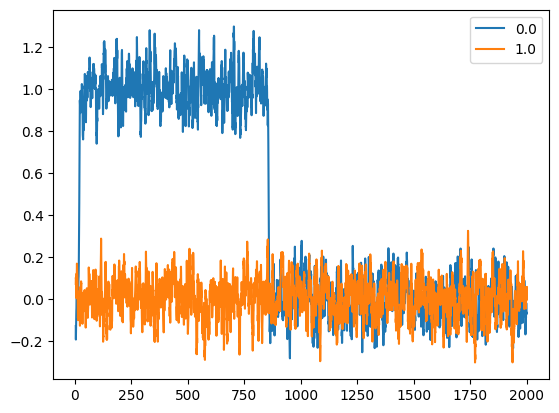

In [7]:
plt.plot(time_filtered,spin_traces_filtered[0], label=spin_number[0])
plt.plot(time_filtered,spin_traces_filtered[1], label=spin_number[1])
plt.legend()

In [ ]:
# Create his

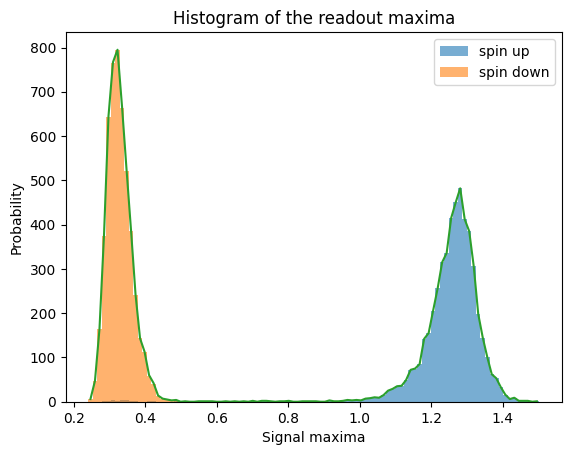

NameError: name 'his_max_up' is not defined

In [9]:
bin_axis_ss,hist_max, his_max_up, hist_max_down=max_simulated_histogram(time_filtered,spin_traces_filtered, spin_number)